Stanislas Deneuville - Emmanuel Ferrandi - Pol Grisart - Marine Médard
# Project of data science :  Face recognition in a video and counting
16/11/2018

## Part II : Train&Use

In [36]:
import random
import keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

The maximum number of faces per image the network will train for 

In [ ]:
MAX_CATEGORY = 11

__split__ : split the set into two well mixed set 


In : 
* data : list of all the images 

Out : 
* train_set : list of the images in the training set representing 66% of data
* test_set : list of the images in the test set representing the other 34% of data

In [37]:
TRAIN_TEST_RATIO = 0.66
def split(data:list, train_test_ratio:int=TRAIN_TEST_RATIO, random_split=True) :
    if random_split:
        # Shuffle
        random.shuffle(data)
    
    # Split data
    cut_index = round(len(data) * train_test_ratio) 
    train_set = data[:cut_index]
    test_set = data[cut_index:]
    return(train_set, test_set)

__Equalize__: cut data subsets to have the same number of images for each possible output value
(Also plot the initial number of sample of each subset) 
In : 
* data : list of list of data elements
Out : 
* equalized data sets : list of list of data elements

In [38]:
def equalize(subsets):
    print("Equalizing subset")
    for nb_face,subset in enumerate(subsets):
        print("{} faces set contains {} images".format(nb_face, len(subset)))
    subsets_length = [len(subset) for subset in subsets]
    
    # plot subsets length
    plt.bar([k for k in range(len(subsets))], subsets_length)
    plt.ylabel('number of sample')
    plt.xlabel('number of faces in sample')
    plt.title('number of sample for each output value')
    plt.show()
    
    minimum = max(100,min(subsets_length))
    cutted_subsets = [subset[:minimum] for subset in subsets]
    return cutted_subsets

__load_and_split__ : Load all the available cleaned data, equalize, split and shuffle it


In : 

Out : 
* train_set : list of the images in the training set representing 66% of data
* test_set : list of the images in the test set representing the other 34% of data

In [ ]:
def load_and_split():
    subsets = [[] for k in range(MAX_CATEGORY+1)]
    for nb_face in range(MAX_CATEGORY+1):
        folder_path = os.path.join("train_set", str(nb_face))
        if (os.path.isdir(folder_path)) :

            # Y value of these alements
            categorical_y = np.zeros((1, MAX_CATEGORY+1))
            categorical_y[0, nb_face] = 1

            folder_path = os.path.join("train_set", str(nb_face))
            for filename in os.listdir(folder_path):
                # Filter non image files
                if ".jpeg" in filename or ".png" in filename or ".jpg" in filename:
                    x = plt.imread(os.path.join(folder_path, filename)).reshape((1, 50,50))
                    y = categorical_y
                    xy = (x,y)
                    subsets[nb_face].append(xy)
    
    # Equalize to have the same number of each Y value
    equalized_subsets = equalize(subsets)
    
    # Split data respecting equalization
    train_set, test_set = [], []
    for subset in equalized_subsets:
        add_train_set, add_test_set = split(subset)
        train_set = train_set + add_train_set
        test_set = test_set + add_test_set
    
    # Shuffle
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    print("Train size = {}, test size = {}".format(len(train_set), len(test_set)))
    
    return train_set, test_set

__AccuracyPlotMemory__: memorise the value of the accuracy all over the training in order to plot it at the end.

In [39]:
class AccuracyPlotMemory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.plot_y = []

    def on_epoch_end(self, batch, logs={}):
        self.plot_y.append(logs.get('acc'))
        
    def plot(self):
        plt.plot([k+1 for k in range(len(self.plot_y))], self.plot_y)
        
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        plt.show()
        
plot_callback = AccuracyPlotMemory()

__train_neuural_network__ : function that creates a neural network and trains it with the train_set 

In [40]:
def generate_model():
    # Simple model
    model = keras.models.Sequential()
    
    # OLD MODEL
    #model.add(keras.layers.Dense(units=500, activation='relu', input_dim=50*50))
    #model.add(keras.layers.Dense(units=100, activation='relu'))
    #model.add(keras.layers.Dense(units=40, activation='relu'))
    #model.add(keras.layers.Dense(units=15, activation='relu'))
    
    
    # Convolutionnal layers
    model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(50,50, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # End with classic layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(3000, activation='relu'))
    #model.add(keras.layers.Dense(700, activation='relu'))  # Trying adding one or two more layers doesn't provide any amelioration
    #model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(MAX_CATEGORY+1, activation='softmax'))
    
    # Define learning process
    # loss choices : categorical_crossentropy or categorical_hinge
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    return model 

def train_neural_network(train_set, test_set=None):
    print("Generating model")
    model = generate_model()
    
    # Convert tain set in a format readable by keras
    x_train = np.concatenate([x for x,y in train_set]).reshape(len(train_set), 50, 50, 1)
    y_train = np.concatenate([y for x,y in train_set])
    print("X train size = {}, y train  size = {}".format(x_train.shape, y_train.shape))
    
    # If test set is provided for a better evaluation during the training 
    xy_test = None
    if test_set is not None:
        # Convert test set in a format readable by keras
        x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
        y_test = np.concatenate([y for x,y in test_set])
        xy_test = x_test, y_test
    
    print("Start training")
    model.fit(x_train, y_train, epochs=30, batch_size=32, callbacks=[plot_callback], validation_data=xy_test)
    
    return model

__evaluate_performance__ : function that applys the neural network on the images in the test_set and compare with the real number of faces in these images 

In [41]:
def evaluate_performance(model, test_set):
    # Convert test set in a format readable by keras
    x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
    y_test = np.concatenate([y for x,y in test_set])
    
    # Evaluate perfoamance
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
    
    # Display accuracy plot
    plot_callback.plot()

Execute all the code

Split
Equalizing subset
0 faces set contains 105 images
1 faces set contains 130 images
2 faces set contains 118 images
3 faces set contains 225 images
4 faces set contains 411 images
5 faces set contains 331 images
6 faces set contains 259 images
7 faces set contains 205 images
8 faces set contains 177 images
9 faces set contains 163 images
10 faces set contains 135 images
11 faces set contains 118 images
12 faces set contains 83 images
13 faces set contains 54 images
14 faces set contains 58 images
15 faces set contains 52 images
16 faces set contains 35 images
17 faces set contains 24 images
18 faces set contains 19 images
19 faces set contains 13 images
20 faces set contains 9 images
21 faces set contains 5 images
22 faces set contains 1 images
23 faces set contains 4 images
24 faces set contains 3 images
25 faces set contains 3 images
26 faces set contains 2 images
27 faces set contains 5 images
28 faces set contains 1 images
29 faces set contains 0 images
30 faces set contains 0 

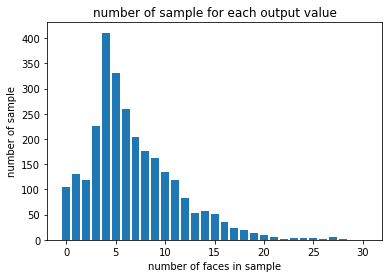

Train size = 1038, test size = 533
Train
Generating model


KeyboardInterrupt: 

In [42]:
print("Split")
train_set, test_set = load_and_split()

print("Train")
model = train_neural_network(train_set)

print("Evaluate")
evaluate_performance(model, test_set)

__manual_evaluation__: provide a clear humain overview of the final performance of network 

In [ ]:
def manual_evaluation(model, test_et):
    x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
    y_test = np.concatenate([y for x,y in test_set])
    outs = model.predict(x_test)
    
    result = [[] for k in range(MAX_CATEGORY + 1)]
    
    square_error = 0
    perfect_accuracy = 0
    count = 0
    
    for y_out, y_expected in zip(outs, y_test):
        #print(">>",y_out,"/expects/",y_expected)
        clean_expected_out = 0
        while not y_expected[clean_expected_out] == 1:
            clean_expected_out += 1
        clean_out = y_out.argmax()
        result[clean_expected_out].append(clean_out)
        
        square_error += abs(clean_expected_out-clean_out)**2
        if clean_out == clean_expected_out:
            perfect_accuracy += 1
        count += 1
        
    #print("==================")
    for k,line in enumerate(result):
        print(k,line)
    
    print("Mean square error {}".format(square_error/count))
    print("perfect match rate {}%".format(round(perfect_accuracy/count*100), 2))
    return square_error/count, perfect_accuracy/count
mean_square_error, perfect_accuracy = manual_evaluation(model, test_set)

Save the network for later reuse 

In [ ]:
#save model

# JSON
json_model = model.to_json()
with open("model_CNN_{}.json".format(round(perfect_accuracy*100)), "w") as f:
    f.write(json_model)
# Weights
model.save_weights("weight_CNN_{}.h5".format(round(perfect_accuracy*100)))
print("Model saved")